# Criação do bot

# Primeiro Passo, Aquisição dos dados

# Candles

Candlestick ou gráfico de candles é um tipo de notação criada por Japoneses no século XVIII onde eles faziam muitas negociações com arroz, como compra venda e contratos futuros.

Desde então essa notação foi amplamente utilizada por traders pois mostram muitas informações esseiciais sobre o estado do preço de um ativo.

### Elementos de um CandleStick

+ ***Período***: O período representa o que ocorreu com o preço de uma ação em um período de tempo, cada candle pode representar 1 minuto, 5 minutos, uma hora, um mês e até um ano. 
+ ***Formato***: O formato do candle representa valores importantes que o preço da ação atingiu em um determinado período de tempo. O modelo OHLC representa
    * Abertura: valor no momento inicial do candle
    * Máximo: valor máximo do ativo no período 
    * Mínimo: valor mínimo do ativo no período
    * Fechamento: Valor ao fim do período
+ ***Cor***: A cor determina se o candle é de alta ou de baixa 
    * Quando o preço de fechamento for maior que o preço de abertura, significa que o preço subiu durante aquele período e o candlestick será de alta.
    * Quando o preço de fechamento está abaixo do preço de abertura, significa que o preço da ação caiu durante aquele determinado período, e o Candle será de baixa.


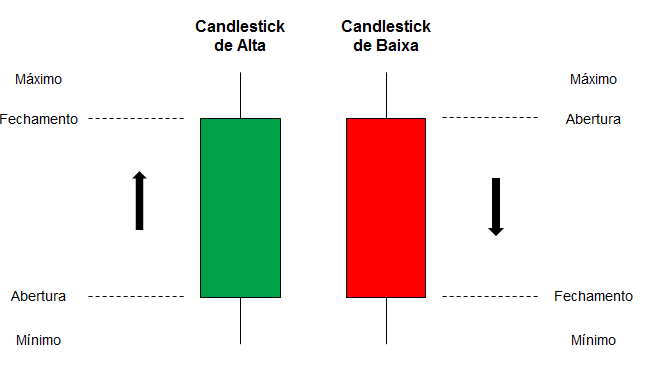

# Pegando os Candles da API

In [1]:
import requests, json
from binance.client import Client
from binance.enums import *

import pandas as pd
import numpy as np

import time
from datetime import datetime

from math import pi
from bokeh.plotting import figure, show, output_file
from bokeh.sampledata.stocks import MSFT
from bokeh.models import Band
%matplotlib inline


class Aquisition(object):
    def __init__(self):
        self.client = Client('', '')
        self.df = ""
        
    def getCandles(self):
        self.df = pd.DataFrame(columns= ['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time'])
        candles = self.client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1DAY)

        opentime, lopen, lhigh, llow, lclose, lvol, closetime = [], [], [], [], [], [], []

        for candle in candles:
            opentime.append(candle[0])
            lopen.append(candle[1])
            lhigh.append(candle[2])
            llow.append(candle[3])
            lclose.append(candle[4])
            lvol.append(candle[5])
            closetime.append(candle[6])

        self.df['Open_time'] = opentime
        self.df["date"] = opentime
        self.df['Open'] = np.array(lopen).astype(np.float)
        self.df['High'] = np.array(lhigh).astype(np.float)
        self.df['Low'] = np.array(llow).astype(np.float)
        self.df['Close'] = np.array(lclose).astype(np.float)
        self.df['Volume'] = np.array(lvol).astype(np.float)
        self.df['Close_time'] = closetime
        self.df["date"] = pd.to_datetime(self.df['date'],unit='ms')
        return self.df
    
    def getPriceNow(self):
        r = requests.get(
            "https://www.binance.com/api/v3/ticker/price?symbol=BTCUSDT")
        r = r.content
        jsonResponse = json.loads(r.decode('utf-8'))
        return float(jsonResponse['price'])
    
    def plotCandles(self):
        df = self.df[450:]
        df["date"] = df["Open_time"]
        df["date"] = pd.to_datetime(self.df['date'],unit='ms')

        inc = df.Close > df.Open
        dec = df.Open > df.Close
        w = 12*60*60*1000 # half day in ms

        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "BITCOIN Candlestick")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3

        p.segment(df.date, df.High, df.date, df.Low, color="black")
        p.vbar(df.date[inc], w, df.Open[inc], df.Close[inc], fill_color="#006400", line_color="black")
        p.vbar(df.date[dec], w, df.Open[dec], df.Close[dec], fill_color="#F2583E", line_color="black")

        output_file("candlestick.html", title="candlestick.py Grafico de Candles")

        show(p)  

# Podemos ver os candles e mostrar com bokeh

In [2]:
aq = Aquisition()
aq.getCandles()
aq.df.head()

,Open_time,Open,High,Low,Close,Volume,Close_time,date
0,1504224000000,4689.89,4885.55,4654.88,4834.91,560.666366,1504310399999,2017-09-01
1,1504310400000,4796.16,4939.19,4286.87,4472.14,929.148595,1504396799999,2017-09-02
2,1504396800000,4508.50,4714.76,4298.33,4509.08,691.216198,1504483199999,2017-09-03
3,1504483200000,4505.00,4527.49,3972.51,4100.11,1394.644614,1504569599999,2017-09-04
4,1504569600000,4106.97,4484.99,3603.00,4366.47,1228.938157,1504655999999,2017-09-05


In [3]:
aq.plotCandles()

/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gabs/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Criando Criando indicadores

### O que são indicadores 

Day traders tomam decisões a partir de gráficos, cada trader usa uma técnica diferente, porém suas estratégiassão agrupadas em algumas categorias. Indicadores são nada mais do quê estratégias estatísticas para mostrar o comportamendo do mercado em determinado período. Geralmente indicadores pretendem mostrar fluxo de ordens, sazonalidade tendências e etc.

Muitos tradders iniciantes se amarram a alguns indicadores crendo que funcionam sempre, o que se caracteriza em um erro grave pois existem inúmeros indicadores que devem ser usados em diferentes momentos. 


Exemplos de indicadores:

***Bandas de Boillinger***

![image.png](https://www.oanda.com/wandacache/2017_bollingerbandsformula-91337ad4d173ccef8e6057242e2188e2fbfc28d2.png)

***RSI***

![image.png](https://www.disnat.com/Content/images/BrokerageNotion/technical-analysis12e.jpg)



## Calculando indicadores

***Bandas de boillinger*** 

In [7]:
class Bbands(Aquisition):  
    
    def __init__(self, nDer = 2, period = 20):
        super(Bbands, self).__init__()
        self.candles = super().getCandles()
        self.nDer = nDer
        self.period = period
    
    def calcBands(self):
        self.candles['30 Day MA'] = self.candles['Close'].rolling(window=self.period).mean()
        self.candles['30 Day STD'] = self.candles['Close'].rolling(window=self.period).std()
        self.candles['Upper Band'] = self.candles['30 Day MA'] + (self.candles['30 Day STD'] * self.nDer)
        self.candles['Lower Band'] = self.candles['30 Day MA'] - (self.candles['30 Day STD'] * self.nDer)
        
    def plotSetting(self, df):
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "Bbands Chart")
        p.xaxis.major_label_orientation = pi/4
        p.grid.grid_line_alpha=0.3
        p.line(df.date, df.Close, line_color="black")
        p.line(df.date, df['30 Day MA'], line_color="red", legend="30 Day MA", muted_alpha=0.2)
        p.line(df.date, df['Upper Band'], line_color="blue", legend="Upper Band", muted_alpha=0.2)
        p.line(df.date, df['Lower Band'], line_color="green", legend="Lower Band", muted_alpha=0.2)
        
        p.legend.location = "top_left"
        p.legend.click_policy="mute"
        return p
        
    def plotBands(self):
        df = self.candles
        p = self.plotSetting(df)
        output_file("candlestick.html", title="candlestick.py Bbands")
        show(p)  
        
    def detectCross(self):
        self.calcBands()
        self.candles['up_cross'] = np.where((self.candles['Close'] >= self.candles['Upper Band'])
                     , self.candles['Close'], 'NaN')
        
        self.candles['down_cross'] = np.where((self.candles['Close'] <= self.candles['Lower Band'])
             , self.candles['Close'],  'NaN')
        
        p = self.plotSetting(self.candles)        
        p.circle(self.candles.date, self.candles['up_cross'], size=5, color="red", alpha=1)
        p.circle(self.candles.date, self.candles['down_cross'], size=5, color="green", alpha=1)
        
        output_file("candlestick.html", title="candlestick.py Bbands")
        show(p)  
        
    def generateSignal(self):
        aq = Aquisition()
        self.candles = aq.getCandles()
        
        ma = self.candles['Close'][480:].mean()
        sma = self.candles['Close'][480:].std()
        ub = ma + (sma * 2)
        lb = ma - (sma * 2)
        print(type(ub))
        price  = aq.getPriceNow()
        
        if(price < lb):
            return 'buy'
        
        if(price > ub):
            return 'sell'
        
        else:
            return 'hold'

In [8]:
bb = Bbands()
bb.calcBands()
bb.plotBands()

In [9]:
bb.detectCross()

# Preparando os dados para a rede neural
A ideia é criar uma rede neural com indicadores como inputs para selecionar o target adequado
## Adicionando outro indicadores

Para facilitar nosso trabalho podemos usar a biblioteca Pyti para análise técnica e calculo dos indicadores


In [10]:
from pyti.exponential_moving_average import exponential_moving_average as ema
from pyti.aroon import aroon_down, aroon_up
from pyti.ichimoku_cloud import tenkansen, kijunsen, chiku_span, senkou_a, senkou_b
from pyti.momentum import momentum

candles = bb.candles
candles = candles.drop(['Open_time', 'Close_time'], axis=1)


candles['EMA - 15'] = ema(candles['Close'].tolist(), 15)
candles['aaron down'] = aroon_down(candles['Close'].tolist(), 25)
candles['aaron up'] = aroon_up(candles['Close'].tolist(), 25)
candles['tenkansen'] = tenkansen(candles['Close'].tolist())
candles['kijunsen'] = kijunsen(candles['Close'].tolist())
#candles['chiku_span'] = chiku_span(candles['Close'].tolist())
#candles['senkou_a'] = senkou_a(candles['Close'].tolist())
#candles['senkou_b'] = senkou_b(candles['Close'].tolist())
candles['momentun'] = momentum(candles['Close'], 15)


candles.head(20)

,Open,High,Low,Close,Volume,date,30 Day MA,30 Day STD,Upper Band,Lower Band,up_cross,down_cross,EMA - 15,aaron down,aaron up,tenkansen,kijunsen,momentun
0,4689.89,4885.55,4654.88,4834.91,560.666366,2017-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4796.16,4939.19,4286.87,4472.14,929.148595,2017-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4508.50,4714.76,4298.33,4509.08,691.216198,2017-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4505.00,4527.49,3972.51,4100.11,1394.644614,2017-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4106.97,4484.99,3603.00,4366.47,1228.938157,2017-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4366.49,4662.87,4335.26,4619.77,807.363726,2017-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4619.77,4788.59,4438.19,4691.61,500.429975,2017-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4691.66,4735.39,4028.93,4282.80,1132.255046,2017-09-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4282.80,4426.62,4150.06,4258.81,658.782952,2017-09-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4467.510,NaN,NaN
9,4258.81,4283.00,3801.00,4130.37,660.373275,2017-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4395.860,NaN,NaN


# Analizando Correlação

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
def corrAll(df):
    plt.figure(figsize=(12,8))
    kwargs = {'fontsize':12,'color':'black'}
    sns.heatmap(df.corr(),annot=True,robust=True)
    plt.title('Correlation Analysis',**kwargs)
    plt.tick_params(length=3,labelsize=12,color='black')
    plt.yticks(rotation=0)
    plt.show()

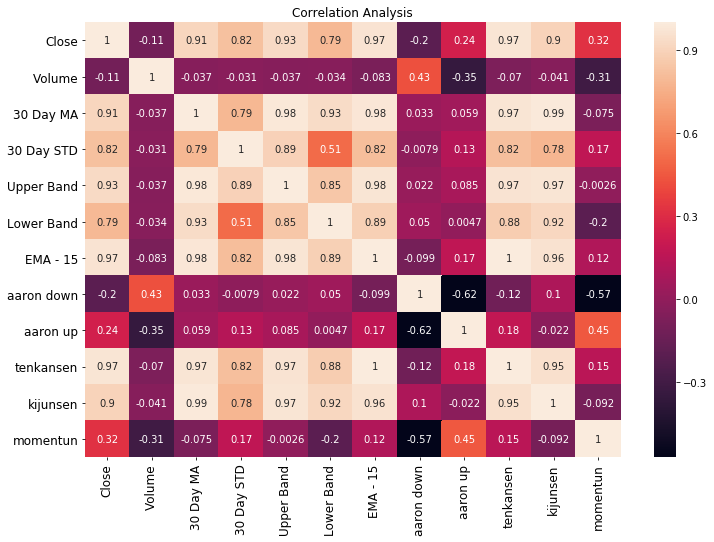

CPU times: user 435 ms, sys: 7.51 ms, total: 442 ms
Wall time: 461 ms


In [12]:
%%time
candles_corr = candles.drop(['High', 'Low', 'Open'], axis=1)
corrAll(candles_corr)

# MEEEEEEEEEEEEEEEEEEH Não ajudou porra nenhuma


# Criando variável target

## Ta bem bosta mas vou pensar uma parada mais elaborada 

# METODO LOOCKAHEAD 10 CANDLES 

### Aqui eh o seguinte

***Eu olho 10 candles a frente e vejo se o preço su***

In [13]:
def testTarget(candles):
    close = candles['Close'].tolist()
    buy, sell, hold = [], [], []
    
    for i in range (0, len(close)-11):
        
        if float(close[i]) < float(close[i+10]):
            buy.append(close[i]) 
            sell.append('NaN')

        elif float(close[i]) > float(close[i+10]):
            buy.append('NaN') 
            sell.append(close[i])
            
    for i in range (488, 500):
        buy.append('NaN') 
        sell.append('NaN')
        
    candles['buy'] = buy
    candles['sell'] = sell

# Hold Option (Não curti muito esse não)

In [279]:
def testTargetwithHold(candles):
    close = candles['Close'].tolist()
    buy, sell, hold = [], [], []
    
    selled = 1
    
    for i in range (0, len(close)-11):
        
        if float(close[i]) < float(close[i+10]) and selled == 1:
            buy.append(close[i]) 
            sell.append('NaN')
            hold.append('NaN')
            selled = 0

        elif float(close[i]) > float(close[i+10]) and selled == 0:
            buy.append('NaN') 
            hold.append('NaN')
            sell.append(close[i])
            selled = 1
        else:
            hold.append(close[i])
            buy.append('NaN') 
            sell.append('NaN') 
            
    for i in range (488, 499):
        buy.append('NaN') 
        sell.append('NaN')
        hold.append('NaN')

    candles['buy'] = buy
    candles['sell'] = sell
    candles['hold'] = hold

In [14]:
testTarget(candles)

# Ver a cagada

In [15]:
TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "Bbands Chart")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.line(candles.date, candles.Close, line_color="black")
      
p.circle(candles.date, candles['sell'], size=5, color="red", alpha=1, legend='buy')
p.circle(candles.date, candles['buy'], size=5, color="green", alpha=1, legend='sell')
#p.circle(candles.date, candles['hold'], size=5, color="yellow", alpha=0.5, legend='hold')

output_file("candlestick.html", title="candlestick.py Bbands")
show(p)  

# Agora criar o target com base na parada de cima ai

In [16]:
candles = candles.drop(['sell', 'buy'], axis=1)
candles.head()

,Open,High,Low,Close,Volume,date,30 Day MA,30 Day STD,Upper Band,Lower Band,up_cross,down_cross,EMA - 15,aaron down,aaron up,tenkansen,kijunsen,momentun
0,4689.89,4885.55,4654.88,4834.91,560.666366,2017-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4796.16,4939.19,4286.87,4472.14,929.148595,2017-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4508.50,4714.76,4298.33,4509.08,691.216198,2017-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4505.00,4527.49,3972.51,4100.11,1394.644614,2017-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4106.97,4484.99,3603.00,4366.47,1228.938157,2017-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
def createTarget(candles):
    close = candles['Close'].tolist()
    target = []
    
    for i in range (0, len(close)-11):
        if float(close[i]) < float(close[i+10]):
            target.append(0)

        elif float(close[i]) > float(close[i+10]):
            target.append(1)
            
    for i in range (488, 500):
        target.append('NaN')
        
    candles['target'] = target

In [22]:
createTarget(candles)

In [23]:
candles.head()

,Open,High,Low,Close,Volume,date,30 Day MA,30 Day STD,Upper Band,Lower Band,up_cross,down_cross,EMA - 15,aaron down,aaron up,tenkansen,kijunsen,momentun,target
0,4689.89,4885.55,4654.88,4834.91,560.666366,2017-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,4796.16,4939.19,4286.87,4472.14,929.148595,2017-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,4508.50,4714.76,4298.33,4509.08,691.216198,2017-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4505.00,4527.49,3972.51,4100.11,1394.644614,2017-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4106.97,4484.99,3603.00,4366.47,1228.938157,2017-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# Decision Tree

# Redes Neurais

## Passo 1 Normalizando os dados

In [244]:
def normalize(timeseries):
    normalized = (timeseries-timeseries.min())/(timeseries.max()-timeseries.min())
    return normalized 

In [245]:
col = candles.columns
col = col[0:len( candles.columns)]
for c in col:
    candles[col] = normalize(candles[col])

ValueError: operands could not be broadcast together with shapes (1000,) (2,) 

# Programação das rotinas do bot

In [182]:
class Orders(object):
    def createOrder(self, side=SIDE_BUY, quantity=100, price='0.00001'):
        try:
            order = Client.create_test_order(
            symbol='USDTBTC',
            side=side,
            type=ORDER_TYPE_LIMIT,
            timeInForce=TIME_IN_FORCE_GTC,
            quantity=quantity,
            price=price)
        except:
            print('erro create order')
        
    def loginAPI(self):
        pass
    

class Bot(object):
    def __init__(self):
        self.botStatus = {
            'openOrder':'none',
            'lastOperation':'sell',
        }
    
    def checkStrategy(self):
        bb = Bbands()
        return bb.generateSignal()
    
    def checkSignal(self):
        signal = self.checkStrategy()
        if(signal == 'buy'):
            self.updateStatus('yes', signal)
        if (signal == 'sell'):
            self.updateStatus('no', signal)
        else:
            pass
    
    def updateStatus(self, status, operation):
        self.botStatus['openOrder'] = status
        self.botStatus['lastOperation'] = operation

In [192]:
#main thread
from IPython.display import clear_output

aq.getCandles()
aq.plotCandles()

bot = Bot()
runtime = 0
while(True):
    bot.checkSignal()
    clear_output()
    print('Runtime = %s seconds' % (runtime))
    time.sleep(2)
    runtime += 2

Runtime = 4 seconds


KeyboardInterrupt: 